# ODC French Fiscal Challenge

# Librairies

In [1]:
import plotly.io as pio
pio.templates.default = "seaborn"

In [2]:
import numpy as np
import pandas as pd

import pickle

import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from matplotlib.colors import rgb2hex

import seaborn as sns

import matplotlib.pyplot as plt

# Load Data
## Locations

In [3]:
with open("data/locations_1.pkl", 'rb') as file:
    object_file = pickle.load(file)
with open("data/locations_2.pkl", 'rb') as file:
    object_file_infs = pickle.load(file)
with open("data/locations_3.pkl", 'rb') as file:
    object_file_3 = pickle.load(file)
with open("data/locations_4.pkl", 'rb') as file:
    object_file_4 = pickle.load(file)

locations_infos = object_file | object_file_infs | object_file_3 | object_file_4

result = {}
for k,v in locations_infos.items():
    municipality = v['address_components'][0]['long_name']
    for e in v['address_components']:
        if "postal_code" in e["types"]:
            postal_code = e['long_name']
    location = v["geometry"]['location']

    result[k] = {"MUNICIPALITY_GMAPS": municipality, "POSTAL_CODE_GMAPS": postal_code, "LAT": location['lat'], "LNG": location['lng']}

In [4]:
df_location = pd.DataFrame.from_dict(result, orient='index')

In [5]:
df_location['LOCATION'] = df_location.index
df_location.reset_index(drop=True, inplace=True)

In [6]:
df_location = df_location.dropna(subset='LOCATION')

In [7]:
df_location['ID'] = -1

# Assign IDs
current_id = 0
unique_coords = {}

for i, row in df_location.iterrows():
    coord = (row['LAT'], row['LNG'])
    if coord not in unique_coords:
        unique_coords[coord] = current_id
        current_id += 1
    df_location.at[i, 'ID'] = unique_coords[coord]

In [8]:
df_location.head()

,MUNICIPALITY_GMAPS,POSTAL_CODE_GMAPS,LAT,LNG,LOCATION,ID
0,Dammarie-lès-Lys,77190,48.515451,2.634831,"DAMMARIE-LES-LYS, SEINE-ET-MARNE",0
1,Juvisy-sur-Orge,91260,48.692871,2.370862,"JUVISY-SUR-ORGE, ESSONNE",1
2,Le Mesnil-Amelot,77990,49.023807,2.599456,"LE MESNIL-AMELOT, SEINE-ET-MARNE",2
3,Le Mesnil-Germain,14140,49.042326,0.190551,"LE MESNIL GERMAIN, CALVADOS",3
4,Revelles,80540,49.849438,2.120952,"REVELLES, SOMME",4


In [9]:
df_i = df_location[df_location.duplicated(subset=['LNG', 'LAT'], keep=False)].sort_values(by=['LNG', 'LAT'])
df_i.head()

,MUNICIPALITY_GMAPS,POSTAL_CODE_GMAPS,LAT,LNG,LOCATION,ID
12134,Saint Martin,87190,18.070830,-63.050081,"SAINT-MARTIN, SAINT-MARTIN",10969
17985,Saint Martin,90150,18.070830,-63.050081,"SAINT MARTIN, SAINT-MARTIN",10969
2989,Pointe-Noire,97116,16.232316,-61.789975,"POINTE-NOIRE, GUADELOUPE",2924
21312,Pointe-Noire,97116,16.232316,-61.789975,"POINTE NOIRE, GUADELOUPE",2924
4045,Bouillante,02810,16.131929,-61.770019,"BOUILLANTE, GUADELOUPE",3919


## French Fiscal data

In [10]:
df = pd.read_csv("data/data.csv")

/var/folders/s8/n6hk73zn1g1chcp__tz8p0mw0000gn/T/ipykernel_76836/950551662.py:1: DtypeWarning: Columns (0,2,3,4,5,6,7,9,10,11,12,14,16,17,18,26,27,29,31,32,33,34,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/data.csv")


### Clean

In [11]:
df = df.drop_duplicates()

df_raw = df.copy(deep=True)
df = df_raw.copy(deep=True)

In [12]:
float_columns = {
    "POPULATION": [
        "POPULATION TOTALE (MUNICIPALE ET COMPTEE A PART)  - Source saisies application FDL"
    ],
    "TH_REVENUE": [
        "TH - SOMME DES ALLOCATIONS COMPENSATRICES / COMMUNE",
        "TH - COMMUNE / MONTANT REEL COMMUNAL AU PROFIT DE LA COMMUNE",
        "TH - MONTANT REEL DE LA MAJORATION DES RESIDENCES SECONDAIRES",
        "TH - Allocation compensatrice TH suppression THLV suite à passage à TLV - COMMUNE",
    ],
    "TH_SYNDICAT": [
        "TH - SYNDICATS ET ORG. ASSIMILES /  MONTANT REEL",
        "TH - SYNDICATS ET ORG. ASSIMILES /  PRODUIT REEL DES LOCAUX VACANTS"
    ],
    "TAFNB_REVENUE": [
        "TAFNB - COMMUNE / MONTANT REEL NET"
    ],
    "FB_REVENUE": [
        "FB - SOMME DES ALLOCATIONS COMPENSATRICES / COMMUNE",
        "FB - COMMUNE / MONTANT REEL"
    ],
    "FB_SYNDICAT": [
        "FB - Dotation abattement 50% VL EI (de droit) - total syndicat / Commune",
        "FB - SYNDICATS ET ORG. ASSIMILES /  MONTANT REEL"
    ],
    "TEOM_REVENUE": [
        "FB - TAXE D'ENLEVEMENT D'O.M. /  TOTAL - MONTANT REEL"
    ],
    "TEOM_SYNDICAT": [
        "FB - TAXE INCITATIVE ENLEVEMENT DES ORDURES MENAGERES / MONTANT REEL / SYNDICAT"
    ],
    "FNB_REVENUE": [
        "FNB - COMMUNE / MONTANT REEL",
        "FNB - SOMME DES ALLOCATIONS COMPENSATRICES / COMMUNE"
    ],
    "FNB_SYNDICAT": [
        "FNB - SYNDICATS ET ORG.ASSIMILES /  MONTANT REEL"
    ],
    "CFE_REVENUE": [
        "CFE - COMMUNE / PRODUIT REEL NET",
        "Part de CVAE au profit de la commune",
        "CFE - SOMME DES ALLOCATIONS COMPENSATRICES / COMMUNE"
    ],
    "CFE_SYNDICAT": [
        "CFE - SYNDICATS ET ORG. ASSIMILES /  PRODUIT REEL NET",
        "CFE - Dotation abattement 50% VL EI (de droit) - total syndicat / Commune"
    ],
    "TASCOM_REVENUE": [
        "TASCOM au profit de la commune"
    ],
    "DCRTP_REVENUE": [
        "DCRTP / Commune"
    ],
    "TVA_REVENUE": [
        "Fraction TVA / Commune"
    ],
    "IFER_REVENUE": [
        "IFER TOTALE / COMMUNE"
    ],
    "FB_RATE": [
        "FB - COMMUNE / TAUX NET"
    ],
    "FNB_RATE": [
        "FNB - COMMUNE / TAUX VOTE"
    ],
    "CFE_RATE": [
        "CFE - COMMUNE /TAUX NET"
    ],
    "TAFNB_RATE": [
        "TAFNB - COMMUNE / TAUX NET"
    ],
    "TH_RATE": [
        "TH - COMMUNE / TAUX NET"
    ],
    "TEOM_RATE": [
        "FB - TAXE D'ENLEVEMENT O.M. /  TAUX PLEIN - TAUX NET"
    ],

}

int_columns = {
    "YEAR": [
        "ANNEE"
    ],
    "COMMUNE": [
        "COMMUNE"
    ]
}

str_columns = {
    "DEPARTEMENT": [
        "DEPARTEMENT"
    ],
    "LIB_COM": [
        "Libellé commune"
    ],
    "LIB_DEP":[
        "LIBELLE DEPARTEMENT"
    ],
    "TEOM_BOOL": [
        "Bénéficiaire de la TEOM (C, I, P ou S)"
    ]
}

all_columns = float_columns | int_columns | str_columns

In [13]:
all_cols = []
for k, v in all_columns.items():
    all_cols.extend(v)

### Numeric, str, int conversions

In [14]:
for key, value in float_columns.items():
    for column_1 in value:
        df[column_1] = pd.to_numeric(df[column_1].astype(str).str.replace(",", "."), errors='coerce')

for key, value in int_columns.items():
    for column_2 in value:
        df[column_2] = df[column_2].astype(str).astype(int)

for key, value in str_columns.items():
    for column_3 in value:
        df[column_3] = df[column_3].astype(str)

Group, sum and rename the columns together from the mapping

In [15]:
columns_to_rename = {}
for key, value in all_columns.items():
    if ("REVENUE" in key) or ("SYNDICAT" in key):
        # Sum the columns listed in the value and assign to a new column named after the key
        df[key] = df[value].sum(axis=1)
    elif len(value) == 1:
        if value[0] != key:
            # Prepare this column to be renamed
            columns_to_rename[value[0]] = key

In [16]:
df = df.rename(columns=columns_to_rename)

In [17]:
df = df[list(all_columns.keys())]

In [18]:
df.columns

Index(['POPULATION', 'TH_REVENUE', 'TH_SYNDICAT', 'TAFNB_REVENUE',
       'FB_REVENUE', 'FB_SYNDICAT', 'TEOM_REVENUE', 'TEOM_SYNDICAT',
       'FNB_REVENUE', 'FNB_SYNDICAT', 'CFE_REVENUE', 'CFE_SYNDICAT',
       'TASCOM_REVENUE', 'DCRTP_REVENUE', 'TVA_REVENUE', 'IFER_REVENUE',
       'FB_RATE', 'FNB_RATE', 'CFE_RATE', 'TAFNB_RATE', 'TH_RATE', 'TEOM_RATE',
       'YEAR', 'COMMUNE', 'DEPARTEMENT', 'LIB_COM', 'LIB_DEP', 'TEOM_BOOL'],
      dtype='object')

Location Cleaning and Merging with data fromm google map API

In [19]:
formatted_DEPARTEMENT = df['DEPARTEMENT'].apply(lambda x: f'{x:0>2}')
formatted_COMMUNE     = df['COMMUNE'].apply(lambda x: f'{x:0>3}')

df['CODE'] = formatted_DEPARTEMENT + formatted_COMMUNE

df['CODE'] = df['CODE'].str.replace('\n', '')

In [20]:
# Fill NaN LIB_DEP value

df['LIB_DEP'].replace('nan', np.nan, inplace=True)
unique_dep = df.dropna(subset=['LIB_DEP']).drop_duplicates(subset=['LIB_COM'])[['LIB_COM', 'LIB_DEP']]
df = df.merge(unique_dep, on=['LIB_COM'], how='left', suffixes=('', '_unique'))
df['LIB_DEP'].fillna(df['LIB_DEP_unique'], inplace=True)
df.drop(columns=['LIB_DEP_unique'], inplace=True)

unique_dep = df.dropna(subset=['LIB_DEP']).drop_duplicates(subset=['CODE'])[['CODE', 'LIB_DEP']]
df = df.merge(unique_dep, on=['CODE'], how='left', suffixes=('', '_unique'))
df['LIB_DEP'].fillna(df['LIB_DEP_unique'], inplace=True)
df.drop(columns=['LIB_DEP_unique'], inplace=True)

/var/folders/s8/n6hk73zn1g1chcp__tz8p0mw0000gn/T/ipykernel_76836/1575968279.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['LIB_DEP'].replace('nan', np.nan, inplace=True)
/var/folders/s8/n6hk73zn1g1chcp__tz8p0mw0000gn/T/ipykernel_76836/1575968279.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [21]:
df['CODE_NAME'] = df['LIB_COM'] + ', ' + df['CODE']
df['CODE_NAME'] = df['CODE_NAME'].str.replace(' *', '')
df['CODE_NAME'] = df['CODE_NAME'].str.replace('*', '')

In [22]:
df['LOCATION'] = df.apply(lambda row: f"{row['LIB_COM']}, {row['LIB_DEP']}" if pd.notna(row['LIB_DEP']) else row['LIB_COM'], axis=1)

In [23]:
ok_location  = df_location['LOCATION'].tolist()
all_location = df['LOCATION'].unique().tolist()

missing_location = list(set(all_location) - set(ok_location))
len(missing_location)

1

In [24]:
missing_location # LOcation not found by Google API

['MOLINGHEM']

In [25]:
len(df_location) # Number of locations

57281

In [26]:
df = pd.merge(df, df_location, on='LOCATION', how='left')

In [27]:
len(df["ID"].unique())

37704

In [28]:
# List of columns to fill
columns_to_fill = ['LAT', 'LNG']

mappings = {}
for column in columns_to_fill:
    mappings[column] = df.groupby('ID')[column].transform(lambda x: x.ffill().bfill())

# Fill NaN values based on the mappings
for column in columns_to_fill:
    df[column] = df[column].combine_first(mappings[column])

### Columns Management to use in the notebook

In [29]:
REVENUE_COLS = [col for col in df.columns if ('RATE' not in col) and ('SYNDICAT' not in col)]
REVENUE      = [col for col in df.columns if 'REVENUE' in col]

RATE_COLS = [col for col in df.columns if ('REVENUE' not in col) and ('SYNDICAT' not in col)]
RATE      = [col for col in df.columns if 'RATE' in col]

SYNDICAT_COLS = [col for col in df.columns if ('REVENUE' not in col) and ('RATE' not in col)]
SYNDICAT      = [col for col in df.columns if 'SYNDICAT' in col]

Aggregations usefull for the questions

In [30]:
REVENUE_AGG = {
    'TH_REVENUE': 'sum',
    'TAFNB_REVENUE': 'sum',
    'FB_REVENUE': 'sum',
    'TEOM_REVENUE': 'sum',
    'FNB_REVENUE': 'sum',
    'CFE_REVENUE': 'sum',
    'TASCOM_REVENUE': 'sum',
    'DCRTP_REVENUE': 'sum',
    'TVA_REVENUE': 'sum',
    'IFER_REVENUE': 'sum',

    'CODE_NAME': lambda x: list(set(list(x))),
    'LNG': 'last',
    'LAT': 'last',
    'TEOM_BOOL': 'last',
    
    'POPULATION': 'sum',
}

TAUX_AGG = {
    'TH_RATE': 'mean',
    'TAFNB_RATE': 'mean',
    'FB_RATE': 'mean',
    'TEOM_RATE': 'mean',
    'FNB_RATE': 'mean',
    'CFE_RATE': 'mean',

    'CODE_NAME': lambda x: list(set(list(x))),
    'LNG': 'last',
    'LAT': 'last',
    'TEOM_BOOL': 'last',
    
    'POPULATION': 'sum',
}

SYNDICAT_AGG = {
    'TH_SYNDICAT': 'sum',
    'FB_SYNDICAT': 'sum',
    'TEOM_SYNDICAT': 'sum',
    'FNB_SYNDICAT': 'sum',
    'CFE_SYNDICAT': 'sum',

    'CODE_NAME': lambda x: list(set(list(x))),
    'LNG': 'last',
    'LAT': 'last',
    'TEOM_BOOL': 'last',
    
    'POPULATION': 'sum',
}

In [31]:
REVENUE

['TH_REVENUE',
 'TAFNB_REVENUE',
 'FB_REVENUE',
 'TEOM_REVENUE',
 'FNB_REVENUE',
 'CFE_REVENUE',
 'TASCOM_REVENUE',
 'DCRTP_REVENUE',
 'TVA_REVENUE',
 'IFER_REVENUE']

In [32]:
# 1 € = 6,55957 FF
df.loc[df['YEAR'] < 2002, REVENUE] = df[REVENUE] / 6.55957 # Convert FF to €

In [33]:
# Check if the TEOM is a revenue for the municipality
def remove_TEOM_type(df, type = 'C'):
    df.loc[df['TEOM_BOOL'] != type, ['TEOM_REVENUE', 'TEOM_RATE']] = np.nan
    return df

In [34]:
df_clean   = remove_TEOM_type(df.copy(deep=True), type = 'C') # Commune / municipality
df_clean_s = remove_TEOM_type(df.copy(deep=True), type = 'S') # Syndicat / labour union

In [35]:
df_clean   = df_clean.drop_duplicates(subset=['ID', 'YEAR', 'LIB_COM'])
df_clean_s = df_clean_s.drop_duplicates(subset=['ID', 'YEAR', 'LIB_COM'])

In [36]:
df_municiplaity      = df_clean.groupby(['ID'], as_index=False).agg(REVENUE_AGG)
df_municiplaity_year = df_clean.groupby(['ID', 'YEAR'], as_index=False).agg(REVENUE_AGG)

df_municiplaity_taux      = df_clean.groupby(['ID'], as_index=False).agg(TAUX_AGG)
df_municiplaity_taux_year = df_clean.groupby(['ID', 'YEAR'], as_index=False).agg(TAUX_AGG)

df_municiplaity_syndicat      = df_clean_s.groupby(['ID'], as_index=False).agg(SYNDICAT_AGG)
df_municiplaity_syndicat_year = df_clean_s.groupby(['ID', 'YEAR'], as_index=False).agg(SYNDICAT_AGG)

## Municipality Ranking

### Revenue

In [37]:
df_municiplaity['REVENUE'] = df_municiplaity[REVENUE].sum(axis=1)

In [38]:
df_municiplaity["REVENUE_PLOT"] = np.cbrt(df_municiplaity["REVENUE"])

In [39]:
df_municiplaity[df_municiplaity["REVENUE"] > 10000000000]["CODE_NAME"].astype(str).unique()

array(["['VILLE DE PARIS, 75056', 'PARIS, 75999', 'PARIS, 75056']"],
      dtype=object)

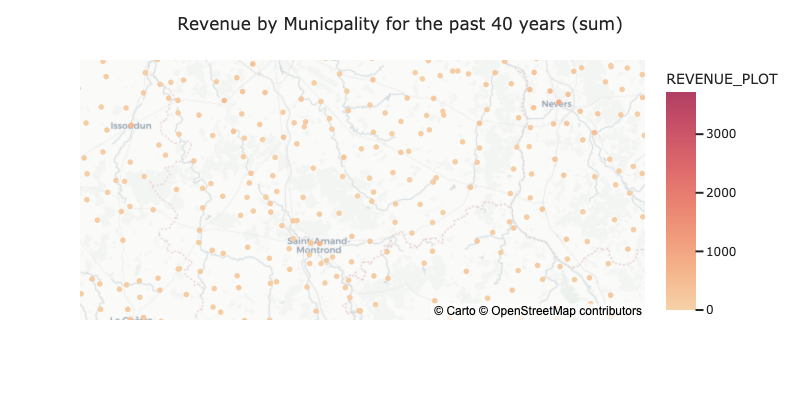

In [40]:
fig = px.scatter_mapbox(df_municiplaity, lat="LAT", lon="LNG", color="REVENUE_PLOT", hover_name="CODE_NAME",
                  mapbox_style="carto-positron", color_continuous_scale='redor')
fig.update_layout(title={'text':'Revenue by Municpality for the past 40 years (sum)'})
fig.update_layout(width=800, height=400)
fig.show("png")

In [41]:
df_municiplaity = df_municiplaity.sort_values('REVENUE')

In [42]:
df_bottom = df_municiplaity.head(5)
df_bottom[["CODE_NAME", "REVENUE"]]

,CODE_NAME,REVENUE
14635,"[CAMOPI, 973056, CAMOPI, 98356]",0.000000
20064,"[ILE-MOLENE, 29084, ILE MOLENE, 29084]",0.000000
37494,"[TALAU, 66200]",1025.372090
11249,"[ILE DE SEIN, 29083, ILE-DE-SEIN, 29083]",4131.000000
14814,"[ROUVROY RIPONT, 51470, ROUVROY-RIPONT, 51470]",4474.896726


In [43]:
df_top = df_municiplaity.tail(5)
df_top[["CODE_NAME", "REVENUE"]]

,CODE_NAME,REVENUE
8496,"[LYON, 69123]",5.468345e+09
23066,"[NICE, 06088]",5.872051e+09
28977,"[TOULOUSE, 31555]",6.180910e+09
24660,"[MARSEILLE, 13055]",7.534103e+09
15688,"[VILLE DE PARIS, 75056, PARIS, 75999, PARIS, 7...",5.146888e+10


In [44]:
df_top.iloc[-1].values

array([15688.0, 859147117.0, 1241836.0, 18036422128.84034, 2467622088.0,
       50392252.321007326, 28549800486.880096, 76757339.0, 0.0,
       1424234659.0, 3260480.0,
       list(['VILLE DE PARIS, 75056', 'PARIS, 75999', 'PARIS, 75056']),
       2.3513765, 48.8575475, 'nan', 59265835.0, 51468878387.04144,
       3719.7598408146], dtype=object)

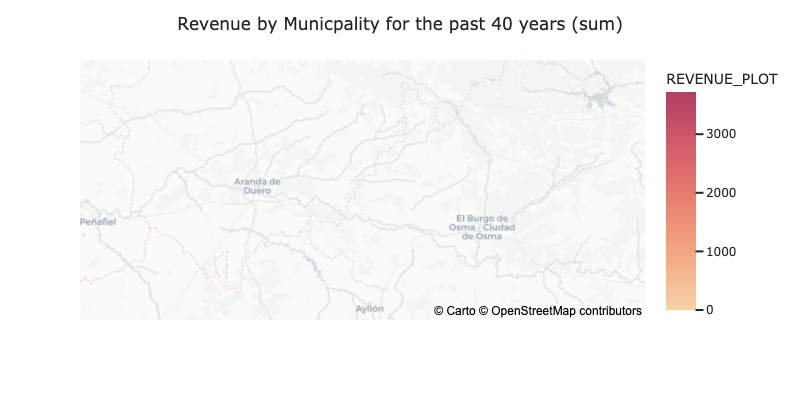

In [45]:
fig = px.scatter_mapbox(pd.concat([df_top, df_bottom]), lat="LAT", lon="LNG", color="REVENUE_PLOT", hover_name="CODE_NAME",
                  mapbox_style="carto-positron", color_continuous_scale='redor')
fig.update_layout(title={'text':'Revenue by Municpality for the past 40 years (sum)'})
fig.update_layout(width=800, height=400)
fig.show("png")

### Rank by Rate

In [46]:
df_municipality_taux_rank = df_municiplaity_taux.copy(deep=True)

In [47]:
df_municiplaity_taux.columns

Index(['ID', 'TH_RATE', 'TAFNB_RATE', 'FB_RATE', 'TEOM_RATE', 'FNB_RATE',
       'CFE_RATE', 'CODE_NAME', 'LNG', 'LAT', 'TEOM_BOOL', 'POPULATION'],
      dtype='object')

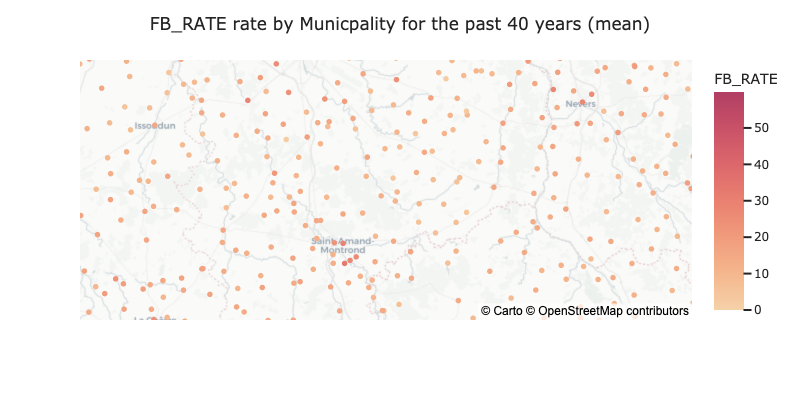

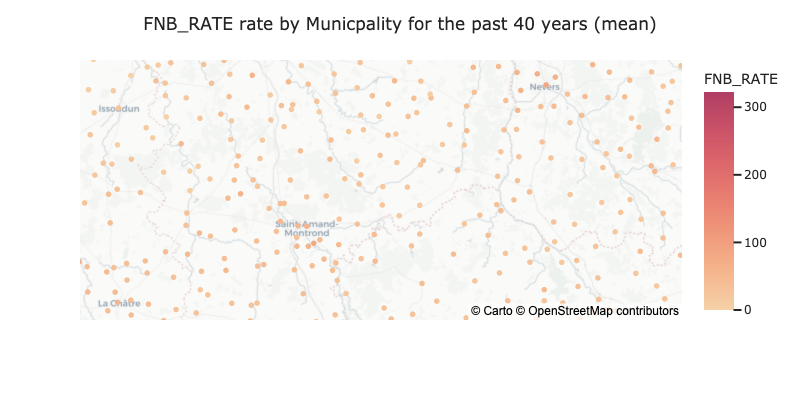

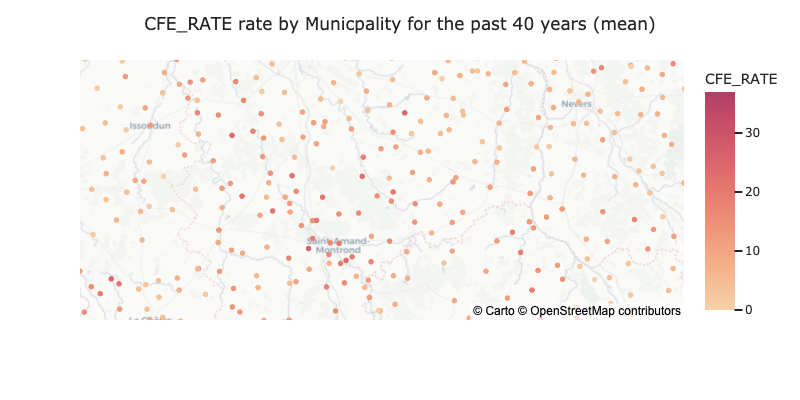

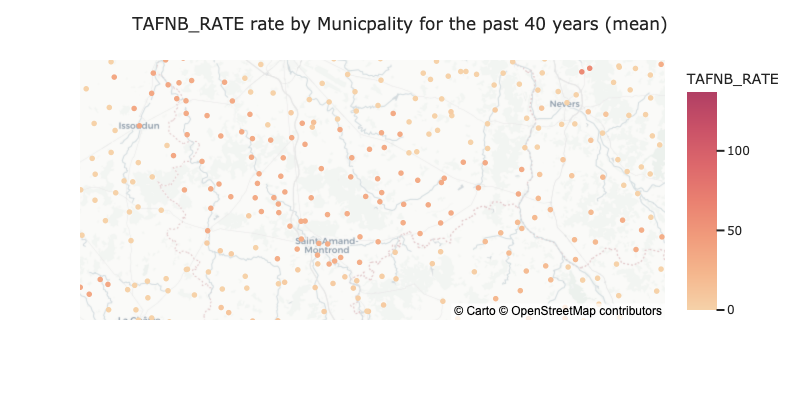

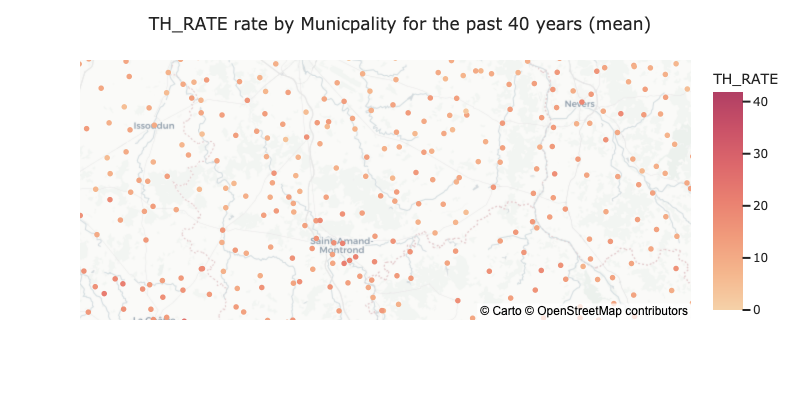

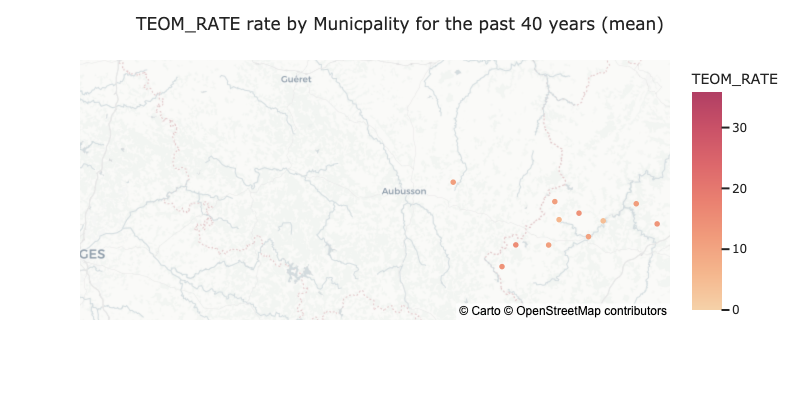

In [48]:
for type_taux in RATE:
    df_municipality_taux_rank.loc[:, f'RANK_{type_taux}'] = df_municipality_taux_rank[type_taux].rank(method='min', ascending=False, na_option='bottom')
    fig = px.scatter_mapbox(df_municipality_taux_rank.dropna(subset=type_taux), lat="LAT", lon="LNG", color=type_taux, hover_name="CODE_NAME",
                  mapbox_style="carto-positron", color_continuous_scale='redor')
    fig.update_layout(title={'text':f'{type_taux} rate by Municpality for the past 40 years (mean)'})
    fig.update_layout(width=800, height=400)
    fig.show("png")

In [49]:
rank_columns = df_municipality_taux_rank.filter(like='RANK_').columns.tolist()
rank_columns

['RANK_FB_RATE',
 'RANK_FNB_RATE',
 'RANK_CFE_RATE',
 'RANK_TAFNB_RATE',
 'RANK_TH_RATE',
 'RANK_TEOM_RATE']

In [50]:
df_municipality_taux_rank['RANK_RATE'] = df_municipality_taux_rank[rank_columns].mean(axis=1, skipna=True).rank(method='min', ascending=True, na_option='bottom')
df_municipality_taux_rank = df_municipality_taux_rank.sort_values('RANK_RATE', ascending=True)

In [51]:
df_top_taux = df_municipality_taux_rank.head(5)
df_top_taux[RATE+ ["CODE_NAME", "RANK_RATE"]]

,FB_RATE,FNB_RATE,CFE_RATE,TAFNB_RATE,TH_RATE,TEOM_RATE,CODE_NAME,RANK_RATE
24233,33.863714,166.3000,22.230857,67.93,20.981143,NaN,"[FONTIERS-CABARDES, 11150, FONTIERS CABARDES, ...",1.0
5692,31.923429,94.8300,31.251429,67.60,25.508000,7.0875,"[SAINT LARY SOULAN, 65388, SAINT-LARY-SOULAN, ...",2.0
22956,24.710286,168.5300,25.713429,96.83,20.820571,NaN,"[ORCIERES, 05096]",3.0
29206,34.372857,118.5825,18.873714,109.30,18.384000,NaN,"[NOGARO, 32296]",4.0
24180,36.039143,97.6700,21.788286,67.93,19.757714,NaN,"[CAUDEBRONDE, 11079]",5.0


In [52]:
df_bottom_taux = df_municipality_taux_rank.tail(5)[RATE+ ["CODE_NAME", "RANK_RATE"]]
df_bottom_taux

,FB_RATE,FNB_RATE,CFE_RATE,TAFNB_RATE,TH_RATE,TEOM_RATE,CODE_NAME,RANK_RATE
37675,NaN,NaN,NaN,NaN,NaN,NaN,"[PIERREPONT EN COTENTIN, 50528]",37680.0
37674,NaN,NaN,NaN,NaN,NaN,NaN,"[LES MESNILS SUR MADON, 54142]",37680.0
37566,NaN,NaN,NaN,NaN,NaN,NaN,"[LICHERES-AIGREMONT, 89224]",37680.0
37497,NaN,NaN,NaN,NaN,NaN,NaN,"[VACQUERIE, 80772]",37680.0
37503,NaN,NaN,NaN,NaN,NaN,NaN,"[HAVYS, 08221]",37680.0


In [53]:
for _, row in df_top.iterrows():
    filtered_df = df_municipality_taux_rank[df_municipality_taux_rank["ID"] == row["ID"]]
    print(row["CODE_NAME"])
    # print(filtered_df[RATE])
    print(rank_columns)
    print(filtered_df[rank_columns].values)
    print()

['LYON, 69123']
['RANK_FB_RATE', 'RANK_FNB_RATE', 'RANK_CFE_RATE', 'RANK_TAFNB_RATE', 'RANK_TH_RATE', 'RANK_TEOM_RATE']
[[17834. 30203. 25206. 18710.  1861.  2112.]]

['NICE, 06088']
['RANK_FB_RATE', 'RANK_FNB_RATE', 'RANK_CFE_RATE', 'RANK_TAFNB_RATE', 'RANK_TH_RATE', 'RANK_TEOM_RATE']
[[ 4265. 22487.  8940. 18710.   629.  2112.]]

['TOULOUSE, 31555']
['RANK_FB_RATE', 'RANK_FNB_RATE', 'RANK_CFE_RATE', 'RANK_TAFNB_RATE', 'RANK_TH_RATE', 'RANK_TEOM_RATE']
[[ 4543.  6729. 17020. 18710.  1101.  1364.]]

['MARSEILLE, 13055']
['RANK_FB_RATE', 'RANK_FNB_RATE', 'RANK_CFE_RATE', 'RANK_TAFNB_RATE', 'RANK_TH_RATE', 'RANK_TEOM_RATE']
[[ 4481. 27527. 33139. 18710.    73.  2112.]]

['VILLE DE PARIS, 75056', 'PARIS, 75999', 'PARIS, 75056']
['RANK_FB_RATE', 'RANK_FNB_RATE', 'RANK_CFE_RATE', 'RANK_TAFNB_RATE', 'RANK_TH_RATE', 'RANK_TEOM_RATE']
[[33458. 31791.  3821. 18709. 16565.  1751.]]



In [54]:
for type_taux in RATE:
    filtered_df = df_municipality_taux_rank.sort_values(f'RANK_{type_taux}', ascending=True).iloc[0]
    print(type_taux)
    print(filtered_df["CODE_NAME"])
    print(filtered_df[f'{type_taux}'])
    print()

FB_RATE
['FONTANES DE SAULT, 11147', 'FONTANES-DE-SAULT, 11147']
59.87028569828571

FNB_RATE
['ST GERMAIN DU TEIL, 48156', 'SAINT-GERMAIN-DU-TEIL, 48156']
322.5

CFE_RATE
['LAGRANGE, 65245']
36.944444440000005

TAFNB_RATE
['SAINT-BONNET-DE-MONTAUROUX, 48139', 'ST BONNET DE MONTAUROUX, 48139']
136.96

TH_RATE
['SAINT-LOUIS, 974014']
41.84666665555556

TEOM_RATE
['JUJOLS, 66090']
35.8499999



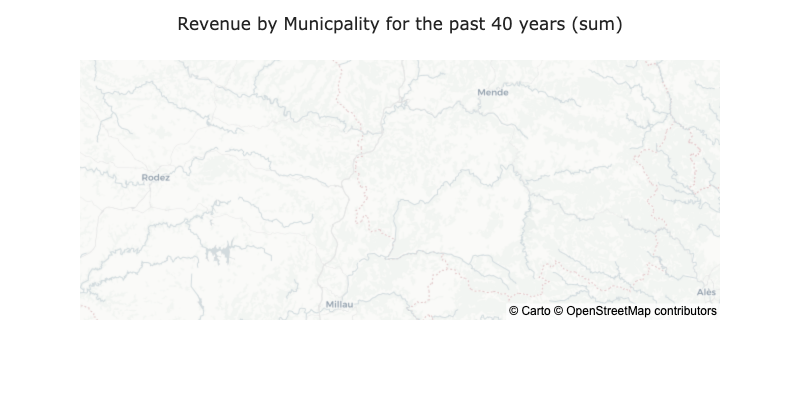

In [55]:
fig = px.scatter_mapbox(pd.concat([df_top, df_top_taux]), lat="LAT", lon="LNG", hover_name="CODE_NAME",
                  mapbox_style="carto-positron", color_continuous_scale='redor')
fig.update_layout(title={'text':'Revenue by Municpality for the past 40 years (sum)'})
fig.update_layout(width=800, height=400)
fig.show("png")

## Revenue Trend

In [56]:
df_municiplaity_year['REVENUE'] = df_municiplaity_year[REVENUE].sum(axis=1)

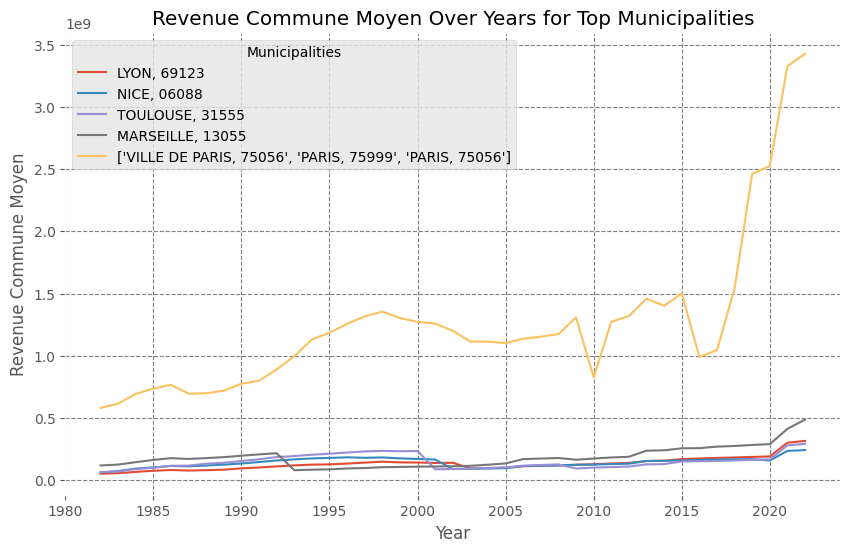

In [57]:
plt.style.use('ggplot')

# Create your plot here
fig, ax = plt.subplots(figsize=(10, 6))

# Set white background
ax.set_facecolor('white')

# Set grey grid
ax.grid(color='grey', linestyle='--')

for idx, row in df_top.iterrows():
    filtered_df = df_municiplaity_year[df_municiplaity_year["ID"] == row["ID"]]
    sns.lineplot(data=filtered_df, x='YEAR', y='REVENUE', label=row['CODE_NAME'], ax=ax)

ax.set_title("Revenue Commune Moyen Over Years for Top Municipalities")
ax.set_xlabel("Year")
ax.set_ylabel("Revenue Commune Moyen")
ax.legend(title="Municipalities")

plt.show()


In [58]:
df_municiplaity_year["REVENUE_PLOT"] = np.log(df_municiplaity_year["REVENUE"])

/Users/lucaordronneau/miniconda3/envs/env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log

/Users/lucaordronneau/miniconda3/envs/env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log



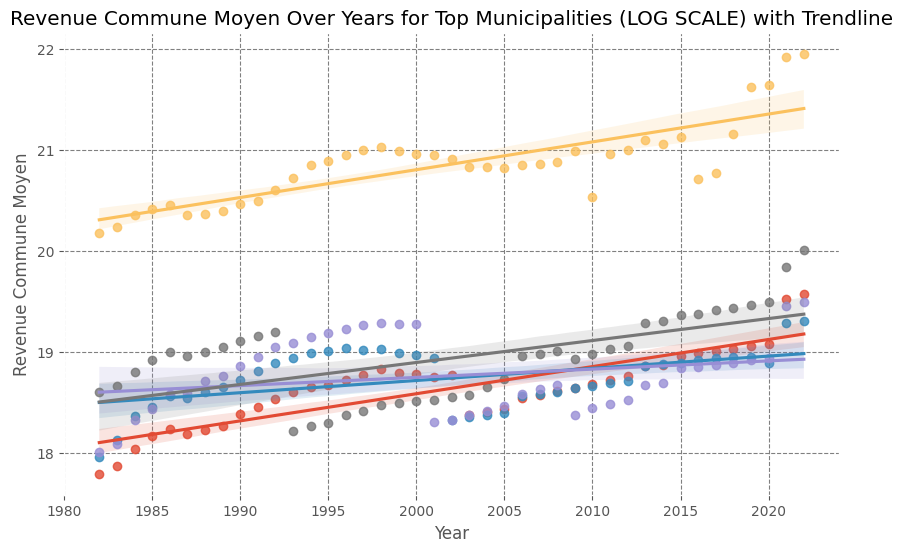

In [59]:
plt.style.use('ggplot')

# Create your plot here
fig, ax = plt.subplots(figsize=(10, 6))

# Set white background
ax.set_facecolor('white')

# Set grey grid
ax.grid(color='grey', linestyle='--')

for idx, row in df_top.iterrows():
    filtered_df = df_municiplaity_year[df_municiplaity_year["ID"] == row["ID"]]
    sns.regplot(data=filtered_df, x='YEAR', y='REVENUE_PLOT', label=row['CODE_NAME'], ax=ax)

ax.set_title("Revenue Commune Moyen Over Years for Top Municipalities (LOG SCALE) with Trendline")
ax.set_xlabel("Year")
ax.set_ylabel("Revenue Commune Moyen")
ax.legend().remove()  # Remove the legend

plt.show()


### By Taux

In [60]:
# Define colors for each taux
palette = sns.color_palette('deep', n_colors=len(RATE))
# Convert the colors to hexadecimal
colors = [rgb2hex(color) for color in palette]

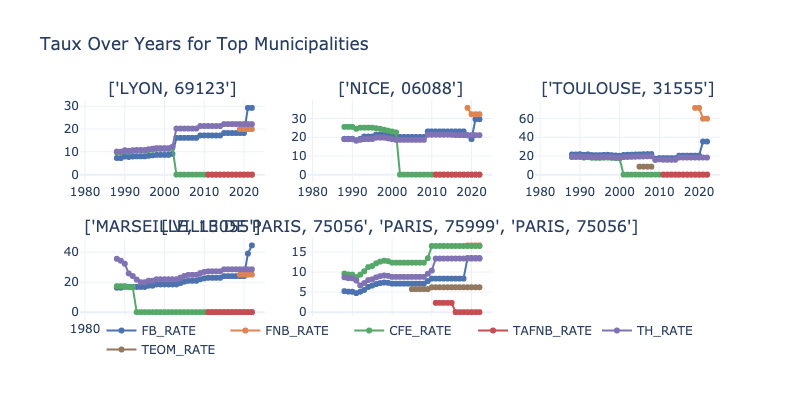

In [61]:
# Map each TAUX to a color
taux_colors = {taux: colors[idx] for idx, taux in enumerate(RATE)}

# Create subplots, 3 cities per row
rows = (len(df_top) + 2) // 3  # This ensures we have enough rows to fit 3 cities per row
fig = make_subplots(rows=rows, cols=3, subplot_titles=df_top['CODE_NAME'].astype(str).tolist())

# Dictionary to track added taux for the legend
taux_added = {taux: False for taux in RATE}

idx = 0
# Iterate over each row in df_top and add the corresponding data to the subplots
for _, row in df_top.iterrows():
    filtered_df = df_municiplaity_taux_year[df_municiplaity_taux_year["ID"] == row["ID"]]
    row_idx = idx // 3 + 1
    col_idx = idx % 3 + 1
    for taux in RATE:
        fig.add_trace(go.Scatter(
            x=filtered_df['YEAR'],
            y=filtered_df[taux],
            mode='lines+markers',
            name=taux if not taux_added[taux] else '',
            showlegend=not taux_added[taux],
            line=dict(color=taux_colors[taux]),
            marker=dict(color=taux_colors[taux])
        ), row=row_idx, col=col_idx)
        taux_added[taux] = True
    
    idx += 1

# Update layout of the plot
fig.update_layout(
    title="Taux Over Years for Top Municipalities",
    height=400 * rows,  # Adjust height based on the number of rows
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5
    ),
    template="plotly_white"
)

# Show the plot
fig.update_layout(width=800, height=400)
fig.show("png")

## Revenue Growth

In [62]:
df_municiplaity_year_growth = df_municiplaity_year.copy(deep=True)

In [63]:
# Constants
end_year = 2022
periods  = [5, 10, 15, 20]

# Prepare the DataFrame
df_municiplaity_year_growth['YEAR'] = pd.to_datetime(df_municiplaity_year_growth['YEAR'], format='%Y')


# Compute growth for each period and each tax rate
result_growth = {}
for period in periods:
    start_year = pd.Timestamp(year=end_year - period, month=1, day=1)

    # Filter for the start and end years
    df_period_start = df_municiplaity_year_growth[df_municiplaity_year_growth['YEAR'] == start_year]
    df_period_end   = df_municiplaity_year_growth[df_municiplaity_year_growth['YEAR'] == pd.Timestamp(year=end_year, month=1, day=1)]


    df_growth = df_period_start.merge(df_period_end, on='ID', suffixes=('_start', '_end'))

    print(df_growth[df_growth['ID'] == 2099][['REVENUE_start', 'REVENUE_end', 'ID']]) 
    
    # Calculate growth rate, handling cases where start is zero or values are the same
    df_growth['GROWTH'] = df_growth.apply(
        lambda row: 0 if row[f'REVENUE_start'] == row[f'REVENUE_end'] or row[f'REVENUE_start'] == 0 else
                    (100 * (row[f'REVENUE_end'] - row[f'REVENUE_start'])/ row[f'REVENUE_start']),
        axis=1
    )

    # Store results in a dictionary
    for index, row in df_growth.iterrows():
        result_growth[f"REVENUE_{row['ID']}_period_{period}"] = row['GROWTH']

      REVENUE_start  REVENUE_end      ID
1779       154255.0     297596.0  2099.0
      REVENUE_start  REVENUE_end      ID
1767       159903.0     297596.0  2099.0
      REVENUE_start  REVENUE_end      ID
1769       141902.0     297596.0  2099.0
      REVENUE_start  REVENUE_end      ID
1659       105977.0     297596.0  2099.0


In [64]:
# Assuming result_growth is filled as per previous steps
data = {
    'ID': [],
    'PERIOD': [],
    'GROWTH': []
}

for key, value in result_growth.items():

    r = key.split('_')
    data['ID'].append(r[1])
    data['PERIOD'].append(r[-1])
    data['GROWTH'].append(value)

df_growth = pd.DataFrame(data)


In [65]:
df_growth.sort_values('GROWTH', ascending=False)

,ID,PERIOD,GROWTH
54924,23159.0,10,1.398708e+08
112633,12139.0,20,8.681915e+07
40842,7204.0,10,1.321922e+07
108638,7204.0,20,5.117058e+06
74931,7204.0,15,3.237286e+06
...,...,...,...
122896,24195.0,20,-9.594020e+01
70107,1630.0,15,-9.598214e+01
36019,1630.0,10,-9.648438e+01
111013,10153.0,20,-9.650662e+01


In [66]:
def categorize_growth(growth, quantiles):
    if growth < quantiles[0]:
        return 'No Growth'
    elif growth >= quantiles[0] and growth < quantiles[1]:
        return 'Low Growth'
    elif growth >= quantiles[1] and growth < quantiles[2]:
        return 'Moderate Growth'
    elif growth >= quantiles[2] and growth < quantiles[3]:
        return 'High Growth'
    else:    
        return 'Very High Growth'

In [67]:
growth_df = []
for p in periods:
    df_tmp_growth = df_growth[df_growth['PERIOD'] == str(p)]
    quantiles = df_tmp_growth['GROWTH'].quantile([0.01, 0.3, 0.6, 0.8])
    quantiles = [0, 50, 100, 250, 500]
    df_tmp_growth['GROWTH_CATEGORY'] = df_tmp_growth['GROWTH'].apply(categorize_growth, args=(quantiles,))
    growth_df.append(df_tmp_growth)

/var/folders/s8/n6hk73zn1g1chcp__tz8p0mw0000gn/T/ipykernel_76836/3550423596.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/s8/n6hk73zn1g1chcp__tz8p0mw0000gn/T/ipykernel_76836/3550423596.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/s8/n6hk73zn1g1chcp__tz8p0mw0000gn/T/ipykernel_76836/3550423596.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [68]:
quantiles

[0, 50, 100, 250, 500]

In [69]:
df_growth = pd.concat(growth_df)

In [70]:
df_growth['ID']   = df_growth['ID'].astype(float)
df_location['ID'] = df_location['ID'].astype(float)

In [71]:
df_growth = pd.merge(df_growth, df_location, on='ID')
df_growth = pd.merge(df_growth, df_municiplaity[["ID", "CODE_NAME"]], on='ID')

In [72]:
df_growth = df_growth[["ID", "PERIOD", "GROWTH", "GROWTH_CATEGORY", "CODE_NAME", "LAT", "LNG"]]

df_growth = df_growth.drop_duplicates(subset=['ID', 'PERIOD'])

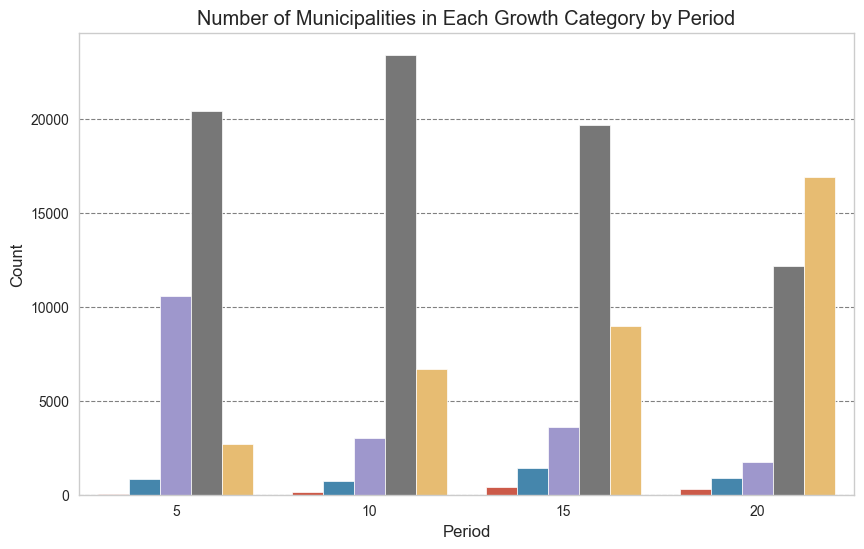

In [73]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set the style
sns.set_style("whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Set the background color
ax.set_facecolor('white')

# Set the grid color
ax.grid(color='grey', linestyle='--')

# Iterate over each period and plot the count for each growth category
for period in periods:
    df_tmp = df_growth[df_growth['PERIOD'] == str(period)]
    sns.countplot(data=df_tmp, x='PERIOD', hue='GROWTH_CATEGORY', ax=ax, order=periods,
                  hue_order=['No Growth', 'Low Growth', 'Moderate Growth', 'High Growth', 'Very High Growth'],)

# Set the labels and title
ax.set_xlabel('Period')
ax.set_ylabel('Count')
ax.set_title('Number of Municipalities in Each Growth Category by Period')


# Show the legend
ax.legend(title='Growth Category')
ax.legend().remove()

# Show the plot
plt.show()

Median Growth by period

In [74]:
for period in periods:
    print(period)
    df_tmp = df_growth[df_growth['PERIOD'] == str(period)]
    print(df_tmp["GROWTH"].median())

5
119.50472542044665
10
169.25209897297663
15
180.8736538753223
20
260.38171177653487


## Correlations

/Users/lucaordronneau/miniconda3/envs/env/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/Users/lucaordronneau/miniconda3/envs/env/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide

/var/folders/s8/n6hk73zn1g1chcp__tz8p0mw0000gn/T/ipykernel_76836/1953845462.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



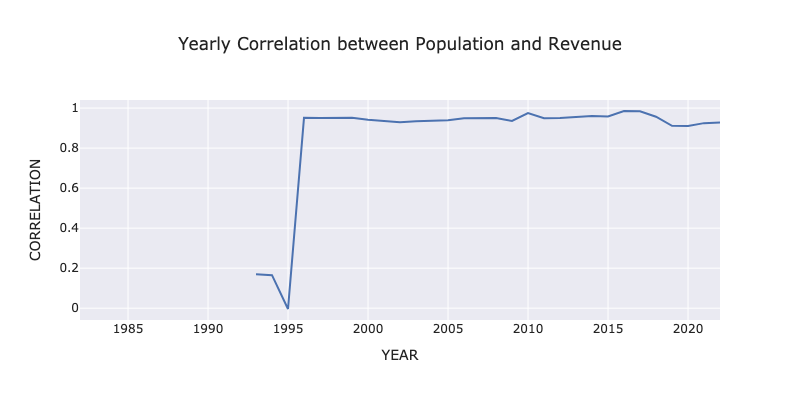

In [75]:
yearly_correlations = df_municiplaity_year.groupby('YEAR').apply(lambda df: df['REVENUE'].corr(df['POPULATION']))

yearly_correlations = yearly_correlations.reset_index()
yearly_correlations.columns = ['YEAR', 'CORRELATION']

fig = px.line(yearly_correlations, x='YEAR', y='CORRELATION',
              title='Yearly Correlation between Population and Revenue',
              labels={'Year': 'Year', 'Correlation': 'Correlation Coefficient'})

# Show the plot
fig.update_layout(width=800, height=400)
fig.show("png")

In [76]:
df_municiplaity_year_corr = df_municiplaity_year.copy(deep=True)

Remove outlier values

In [77]:
df_municiplaity_year_corr.loc[df_municiplaity_year_corr["POPULATION"] < 10] = np.nan

In [78]:
df_municiplaity_year_corr = df_municiplaity_year_corr.dropna(subset=['POPULATION'])

In [79]:
# Filter df_municiplaity_year for different time periods
df_municiplaity_year_all_time = df_municiplaity_year_corr

# Calculate correlations
correlation_all_time = np.corrcoef(df_municiplaity_year_all_time['POPULATION'], df_municiplaity_year_all_time['REVENUE'])[0, 1]

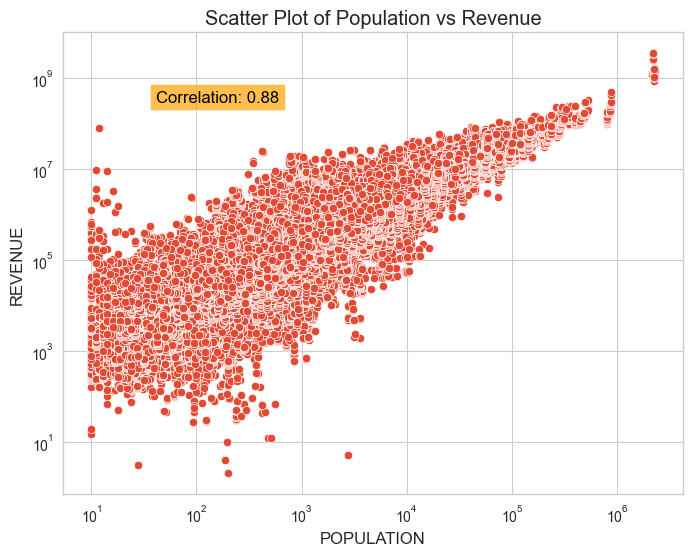

In [80]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create a figure
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot for all time
sns.scatterplot(data=df_municiplaity_year_all_time, x='POPULATION', y='REVENUE', ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Scatter Plot of Population vs Revenue')
ax.annotate(f'Correlation: {correlation_all_time:.2f}', xy=(0.15, 0.85), xycoords='axes fraction', 
                    fontsize=12, color='black', bbox=dict(facecolor='orange', alpha=0.7))

# Show the plot
plt.show()


## Significant Taxes

In [81]:
df_municiplaity_syndicat['REVENUE']      = df_municiplaity_syndicat[SYNDICAT].sum(axis=1)
df_municiplaity_syndicat_year['REVENUE'] = df_municiplaity_syndicat_year[SYNDICAT].sum(axis=1)

In [82]:
df_municiplaity['REVENUE'].sum()

701838293000.4335

In [83]:
df_municiplaity_syndicat['REVENUE'].sum()

36784060330.0

### Calculate for each tax revenue the representation compared to the global revenue

In [84]:
def calculate_revenue_percentage(row):
    total_revenue = row['REVENUE']
    percentages = {revenue: (row[revenue] / total_revenue * 100) if total_revenue else 0 for revenue in REVENUE}
    return percentages

# Apply the function to each row
df_percentages = df_municiplaity.apply(calculate_revenue_percentage, axis=1)

def calculate_syndicat_percentage(row):
    total_revenue = row['REVENUE']
    percentages = {revenue: (row[revenue] / total_revenue * 100) if total_revenue else 0 for revenue in SYNDICAT}
    return percentages

# Apply the function to each row
df_percentages_syndicat = df_municiplaity_syndicat.apply(calculate_syndicat_percentage, axis=1)

In [85]:
df_transformed          = pd.DataFrame(df_percentages.tolist())
df_transformed_syndicat = pd.DataFrame(df_percentages_syndicat.tolist())

In [86]:
aggregate_percentages = 100 * df_transformed.sum() / df_transformed.sum().sum()

In [87]:
aggregate_percentages_syndicat = 100 * df_transformed_syndicat.sum() / df_transformed_syndicat.sum().sum()

In [88]:
df_transformed          = pd.DataFrame(aggregate_percentages).T
df_transformed_syndicat = pd.DataFrame(aggregate_percentages_syndicat).T

In [89]:
df_transformed.columns

Index(['TH_REVENUE', 'TAFNB_REVENUE', 'FB_REVENUE', 'TEOM_REVENUE',
       'FNB_REVENUE', 'CFE_REVENUE', 'TASCOM_REVENUE', 'DCRTP_REVENUE',
       'TVA_REVENUE', 'IFER_REVENUE'],
      dtype='object')

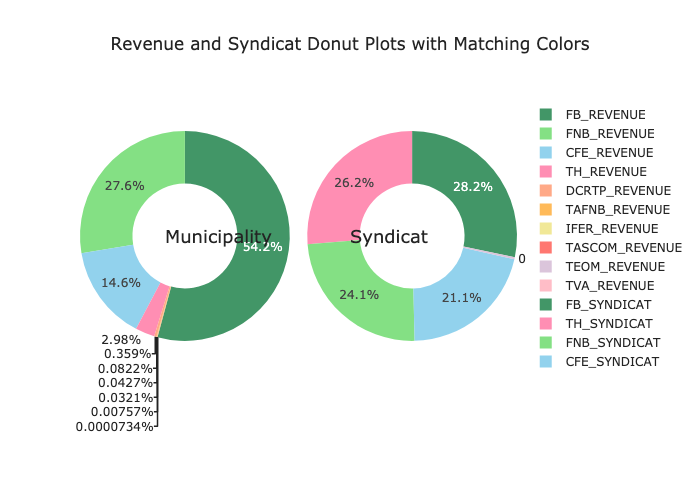

In [137]:
import pandas as pd
import plotly.graph_objects as go

# Define colors for matching prefixes
prefixes = set(col.split('_')[0] for col in df_transformed.columns).union(
    set(col.split('_')[0] for col in df_transformed_syndicat.columns))

strong_colors = [
    "rgba(255, 105, 97, 0.9)",   # Strong red
    "rgba(255, 179, 71, 0.9)",   # Strong orange
    "rgba(240,230,140,0.9)",  # Strong yellow
    "rgba(119, 221, 119, 0.9)",  # Strong green
    "rgba(135, 206, 235, 0.9)",  # Strong blue
    "rgba(216, 191, 216, 0.9)",  # Strong purple
    "rgba(255, 130, 171, 0.9)",  # Strong pink
    "rgba(255, 182, 193, 0.9)",  # Strong light pink
    "rgba(46,139,87,0.9)",   # Strong yellow-green
    "rgba(255, 160, 122, 0.9)"   # Strong coral
]

colors = {prefix: strong_colors[i % len(strong_colors)] for i, prefix in enumerate(prefixes)}



# Prepare data for the plots
revenue_data = {col: df_transformed[col].iloc[0] for col in df_transformed.columns}
syndicat_data = {col: df_transformed_syndicat[col].iloc[0] for col in df_transformed_syndicat.columns}

# Create the donut plots
fig = go.Figure()

# Donut plot for revenue
fig.add_trace(go.Pie(
    labels=list(revenue_data.keys()),
    values=list(revenue_data.values()),
    hole=0.5,
    marker=dict(colors=[colors[col.split('_')[0]] for col in revenue_data.keys()]),
    domain=dict(x=[0, 0.48]),
    name="Revenue"
))

# Donut plot for syndicat
fig.add_trace(go.Pie(
    labels=list(syndicat_data.keys()),
    values=list(syndicat_data.values()),
    hole=0.5,
    marker=dict(colors=[colors[col.split('_')[0]] for col in syndicat_data.keys()]),
    domain=dict(x=[0.52, 1]),
    name="Syndicat"
))

# Update layout for the figure
fig.update_layout(
    title_text="Revenue and Syndicat Donut Plots with Matching Colors",
    annotations=[dict(text='Municipality', x=0.19, y=0.5, font_size=18, showarrow=False),
                 dict(text='Syndicat', x=0.8, y=0.5, font_size=18, showarrow=False)]
)

fig.show("png")


In [91]:
df_transformed_syndicat

,TH_SYNDICAT,FB_SYNDICAT,TEOM_SYNDICAT,FNB_SYNDICAT,CFE_SYNDICAT
0,26.236269,28.234304,0.323963,24.138975,21.066489


### By year

In [92]:
df_year = df_municiplaity_year.groupby('YEAR').agg({
    "TH_REVENUE": "sum",
    "TAFNB_REVENUE": "sum",
    "FB_REVENUE": "sum",
    "TEOM_REVENUE": "sum",
    "FNB_REVENUE": "sum",
    "CFE_REVENUE": "sum",
    "TASCOM_REVENUE": "sum",
    "DCRTP_REVENUE": "sum",
    "TVA_REVENUE": "sum",
    "IFER_REVENUE": "sum",
    "POPULATION": "sum",
    "REVENUE": "sum"
})

df_year_syndicat = df_municiplaity_syndicat_year.groupby('YEAR').agg({
    "TH_SYNDICAT": "sum",
    "FB_SYNDICAT": "sum",
    "TEOM_SYNDICAT": "sum",
    "FNB_SYNDICAT": "sum",
    "CFE_SYNDICAT": "sum",
    "POPULATION": "sum",
    "REVENUE": "sum"
})

In [93]:
year_percentages = df_year.apply(calculate_revenue_percentage, axis=1)

df_year_percentages = pd.DataFrame(year_percentages.tolist())
df_year_percentages["YEAR"] = year_percentages.index

year_percentages_syndicat = df_year_syndicat.apply(calculate_syndicat_percentage, axis=1)

df_year_percentages_syndicat = pd.DataFrame(year_percentages_syndicat.tolist())
df_year_percentages_syndicat["YEAR"] = year_percentages_syndicat.index

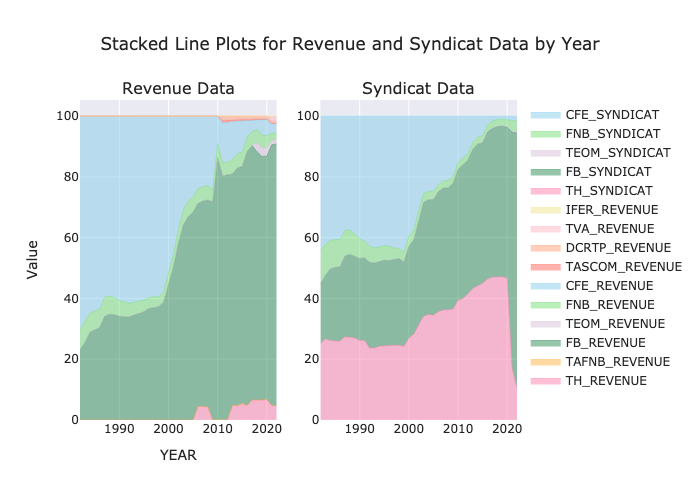

In [136]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Revenue Data", "Syndicat Data"))

# Add traces for df_year_percentages
for col in df_year_percentages.columns:
    if col != 'YEAR':
        prefix = col.split('_')[0]
        fig.add_trace(go.Scatter(
            x=df_year_percentages['YEAR'],
            y=df_year_percentages[col],
            mode='lines',
            stackgroup='one',
            name=col,
            line=dict(width=0.5, color=colors[prefix])
        ), row=1, col=1)

# Add traces for df_year_percentages_syndicat
for col in df_year_percentages_syndicat.columns:
    if col != 'YEAR':
        prefix = col.split('_')[0]
        fig.add_trace(go.Scatter(
            x=df_year_percentages_syndicat['YEAR'],
            y=df_year_percentages_syndicat[col],
            mode='lines',
            stackgroup='one',
            name=col,
            line=dict(width=0.5, color=colors[prefix])
        ), row=1, col=2)

# Update layout for the figure
fig.update_layout(
    title_text="Stacked Line Plots for Revenue and Syndicat Data by Year",
    xaxis_title="YEAR",
    yaxis_title="Value",
    showlegend=True
)

fig.show("png")


## Taxe professionnelle

In [95]:
df_municiplaity_year_tmp = df_municiplaity_year.groupby('YEAR').agg({"CFE_REVENUE": "sum", "DCRTP_REVENUE": "sum", "IFER_REVENUE": "sum", "TVA_REVENUE": "sum"})

In [96]:
revenue_to_post_2010 = df_municiplaity_year[df_municiplaity_year["YEAR"] > 2010]["REVENUE"].sum()
revenue_to_pre_2010  = df_municiplaity_year[df_municiplaity_year["YEAR"] <= 2010]["REVENUE"].sum()

In [97]:
df_municiplaity_year_tmp["TP_CFE"] = df_municiplaity_year_tmp["DCRTP_REVENUE"] + df_municiplaity_year_tmp["CFE_REVENUE"] + df_municiplaity_year_tmp["IFER_REVENUE"] + df_municiplaity_year_tmp["TVA_REVENUE"]

<Axes: xlabel='YEAR'>

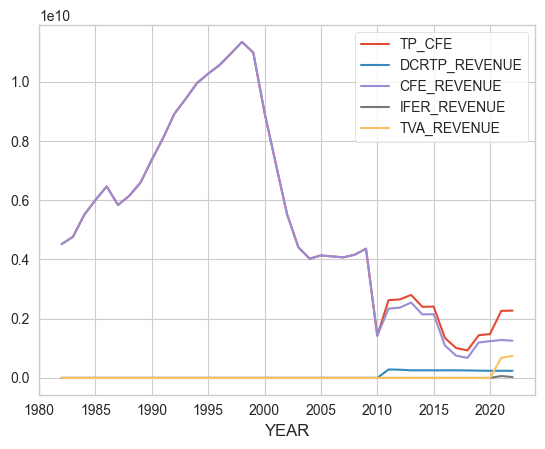

In [98]:
df_municiplaity_year_tmp[["TP_CFE", "DCRTP_REVENUE", "CFE_REVENUE", "IFER_REVENUE", "TVA_REVENUE"]].plot()

In [99]:
df_pre_2010 = df_municiplaity_year_tmp[(df_municiplaity_year_tmp.index <= 2010)]

In [100]:
df_post_2010 = df_municiplaity_year_tmp[df_municiplaity_year_tmp.index > 2010]

<Axes: xlabel='YEAR'>

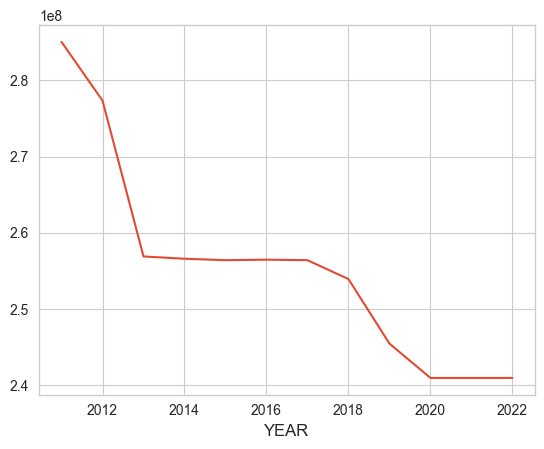

In [101]:
df_post_2010["DCRTP_REVENUE"].plot()

In [102]:
df_pre_2010.mean()

CFE_REVENUE      6.763167e+09
DCRTP_REVENUE    0.000000e+00
IFER_REVENUE     0.000000e+00
TVA_REVENUE      0.000000e+00
TP_CFE           6.763167e+09
dtype: float64

In [103]:
df_post_2010.mean()

CFE_REVENUE      1.587654e+09
DCRTP_REVENUE    2.556335e+08
IFER_REVENUE     7.788070e+06
TVA_REVENUE      1.186862e+08
TP_CFE           1.969761e+09
dtype: float64

In [104]:
sum_TP_revenue    = df_pre_2010["CFE_REVENUE"].sum()
sum_DCRTP_revenue = df_post_2010["DCRTP_REVENUE"].mean()

sum_IFER_revenue  = df_post_2010["IFER_REVENUE"].mean()
sum_TVA_revenue   = df_post_2010["TVA_REVENUE"].mean()
sum_CFE_revenue   = df_post_2010["CFE_REVENUE"].mean()

# sum_all_revenue    = df_pre_2010["REVENUE"].sum()
# sum_all_revenue_post    = df_post_2010["REVENUE"].sum()

print("DCRTP", 100 * sum_DCRTP_revenue / df_pre_2010.iloc[-1]["TP_CFE"])
print("IFER", 100 * sum_IFER_revenue / df_pre_2010.iloc[-1]["TP_CFE"])
print("TVA", 100 * sum_TVA_revenue / df_pre_2010.iloc[-1]["TP_CFE"])
print("CFE", 100 * sum_CFE_revenue / df_pre_2010.iloc[-1]["TP_CFE"])
print("All", 100 * (sum_DCRTP_revenue + sum_IFER_revenue + sum_TVA_revenue + sum_CFE_revenue) / df_pre_2010.iloc[-1]["TP_CFE"])
print("All without DCRTP", 100 * (sum_IFER_revenue + sum_TVA_revenue + sum_CFE_revenue) / df_pre_2010.iloc[-1]["TP_CFE"])

# print("TP representation pre 2010", 100 * sum_TP_revenue / sum_all_revenue)
# print("TP representation post 2010", 100 * (sum_DCRTP_revenue + sum_IFER_revenue + sum_TVA_revenue + sum_CFE_revenue) / sum_all_revenue_post)

DCRTP 17.92729013830812
IFER 0.5461686018404057
TVA 8.323330881492373
CFE 111.34036197010913
All 138.13715159175
All without DCRTP 120.20986145344189


In [105]:
100 * df_post_2010["TP_CFE"].sum() / revenue_to_post_2010

8.223877264615432

In [106]:
100 * df_pre_2010["TP_CFE"].sum() / revenue_to_pre_2010

47.32711907112682

## ML Model

In [107]:
df_municiplaity_year.columns

Index(['ID', 'YEAR', 'TH_REVENUE', 'TAFNB_REVENUE', 'FB_REVENUE',
       'TEOM_REVENUE', 'FNB_REVENUE', 'CFE_REVENUE', 'TASCOM_REVENUE',
       'DCRTP_REVENUE', 'TVA_REVENUE', 'IFER_REVENUE', 'CODE_NAME', 'LNG',
       'LAT', 'TEOM_BOOL', 'POPULATION', 'REVENUE', 'REVENUE_PLOT'],
      dtype='object')

In [108]:
df_year = df_municiplaity_year.groupby('YEAR').agg({
    "TH_REVENUE": "sum",
    "TAFNB_REVENUE": "sum",
    "FB_REVENUE": "sum",
    "TEOM_REVENUE": "sum",
    "FNB_REVENUE": "sum",
    "CFE_REVENUE": "sum",
    "TASCOM_REVENUE": "sum",
    "DCRTP_REVENUE": "sum",
    "TVA_REVENUE": "sum",
    "IFER_REVENUE": "sum",
    "POPULATION": "sum",
    "REVENUE": "sum"
})

df_taux_year = df_municiplaity_taux_year.groupby('YEAR').agg({
    "TH_RATE": "mean",
    "TAFNB_RATE": "mean",
    "FB_RATE": "mean",
    "TEOM_RATE": "mean",
    "FNB_RATE": "mean",
    "CFE_RATE": "mean",
})

In [109]:
df_data = pd.merge(df_year, df_taux_year, on='YEAR')

In [110]:
data = [
    (2022, 5.22, 3.58),
    (2021, 1.64, 1.17),
    (2020, 0.48, -0.63),
    (2019, 1.11, -0.74),
    (2018, 1.85, 0.82),
    (2017, 1.03, 0.85),
    (2016, 0.18, 0.15),
    (2015, 0.04, -0.47),
    (2014, 0.51, -0.36),
    (2013, 0.86, -1.09),
    (2012, 1.95, -0.16),
    (2011, 2.11, 0.58),
    (2010, 1.53, 1.44),
    (2009, 0.09, -2.73),
    (2008, 2.81, 1.32),
    (2007, 1.49, -0.19),
    (2006, 1.68, -0.07),
    (2005, 1.75, -0.40),
    (2004, 2.14, 0.04),
    (2003, 2.10, 0.18),
    (2002, 1.92, 0.29),
    (2001, 1.63, -0.04),
    (2000, 1.68, 1.14),
    (1999, 0.54, -0.11),
    (1998, 0.65, -0.55),
    (1997, 1.20, -0.78),
    (1996, 1.98, 0.19),
    (1995, 1.80, 0.14),
    (1994, 1.66, -0.45),
    (1993, 2.10, -0.26),
    (1992, 2.36, -0.85),
    (1991, 3.21, 0.02),
    (1990, 3.19, -0.30),
    (1989, 3.50, 0.80),
    (1988, 2.70, -0.59),
    (1987, 3.29, 0.75),
    (1986, 2.54, -3.29),
    (1985, 5.83, -1.84),
    (1984, 7.67, -1.79),
    (1983, 9.46, -2.52),
    (1982, 1.98, -1.34)
]

# Create a DataFrame with the data
df_inflation = pd.DataFrame(data, columns=['YEAR', 'INFLATION_RATE', 'ANNUAL_CHANGE'])

In [111]:
df_data = pd.merge(df_data, df_inflation, on="YEAR")

In [112]:
df_data.loc[df_data["POPULATION"] < 1000000, "POPULATION"] = 0.0

In [113]:
LAG_COLS = ['TH_REVENUE', 'TAFNB_REVENUE', 'FB_REVENUE', 'TEOM_REVENUE', 'FNB_REVENUE', 'CFE_REVENUE', 'DCRTP_REVENUE', 'TVA_REVENUE', 'TASCOM_REVENUE', 'IFER_REVENUE', 'POPULATION', 'INFLATION_RATE', 'ANNUAL_CHANGE']
for col in LAG_COLS:
    df_data[col] = df_data[col].shift()

In [114]:
import numpy as np

# Handling missing values
df_data.fillna(0, inplace=True)  # Assuming missing rates are zero

# Feature creation
# Revenue ratios for each tax type
tax_types = ['TH', 'TAFNB', 'FB', 'TEOM', 'FNB', 'CFE', 'TASCOM', 'IFER']

# Year-on-year growth rates for each tax and total revenue
for tax in tax_types:
    df_data[f'{tax}_REVENUE_GROWTH'] = df_data[f'{tax}_REVENUE'].pct_change()
df_data['REVENUE_GROWTH'] = df_data['REVENUE'].pct_change()

# Adding population growth if population df_data gets corrected
if 'POPULATION' in df_data.columns and df_data['POPULATION'].max() > 0:  # Checking if population df_data is sensible
    df_data['POPULATION_GROWTH'] = df_data['POPULATION'].pct_change()

# 2. Per Capita Tax Revenue
for tax in tax_types:
    df_data[f'{tax}_PER_CAPITA_REVENUE'] = df_data[f'{tax}_REVENUE'] / df_data['POPULATION']
    df_data[f'{tax}_PER_REVENUE_RATIO']  = df_data['POPULATION'] / df_data[f'{tax}_REVENUE'] 

# Calculate cumulative inflation adjustment factors
inflation_factors = (1 + df_data['INFLATION_RATE'] / 100).cumprod()

# Adjust tax revenues for inflation
for tax in tax_types:
    df_data[f'{tax}_INFLATION_ADJUSTED_REVENUE'] = df_data[f'{tax}_REVENUE'] * inflation_factors

# Economic impact features
df_data['INFLATION_RATE_CHANGE'] = df_data['INFLATION_RATE'].diff()  # Year-on-year change in inflation
df_data['INFLATION_REVENUE_INTERACTION'] = df_data['INFLATION_RATE_CHANGE'] * df_data['REVENUE_GROWTH']

# Ensure all new features handle any potential infinite or NaN values
df_data.replace([np.inf, -np.inf], 0, inplace=True)
df_data.fillna(0, inplace=True)

In [115]:
df_sub_data = df_data[1:]

In [116]:
from scipy.stats import boxcox

# The original data must be positive. If not, you may need to shift the data.
df_sub_data['REVENUE'], fitted_lambda = boxcox(df_sub_data['REVENUE'])  

/var/folders/s8/n6hk73zn1g1chcp__tz8p0mw0000gn/T/ipykernel_76836/3943405201.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [117]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming 'df_sub_data' is your DataFrame and it's already loaded
# Let's say we use the last 2 YEARs for testing
test_years = [df_sub_data['YEAR'].max() - 2, df_sub_data['YEAR'].max() - 1, df_sub_data['YEAR'].max()]
train_data = df_sub_data[~df_sub_data['YEAR'].isin(test_years)]
test_data  = df_sub_data[df_sub_data['YEAR'].isin(test_years)]

X_train = train_data.drop(["REVENUE", "YEAR"], axis=1)
y_train = train_data['REVENUE']
X_test  = test_data.drop(["REVENUE", "YEAR"], axis=1)
y_test  = test_data['REVENUE']

### Prophet

In [119]:
from prophet import Prophet

In [120]:
# Assuming 'YEAR' is the column with the YEAR information and 'REVENUE' is the target
df_prophet = pd.DataFrame({
    'ds': pd.to_datetime(df_data['YEAR'], format='%Y'),
    'y': df_data['REVENUE']
})

for rate in RATE:
    df_prophet[rate] = df_data[rate]

# Split data - let's use the last 2 YEARs for testing in this context
df_train = df_prophet[df_prophet['ds'].dt.year < df_data['YEAR'].max() - 2]
df_test  = df_prophet[df_prophet['ds'].dt.year >= df_data['YEAR'].max() - 2]


/var/folders/s8/n6hk73zn1g1chcp__tz8p0mw0000gn/T/ipykernel_76836/1959309081.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




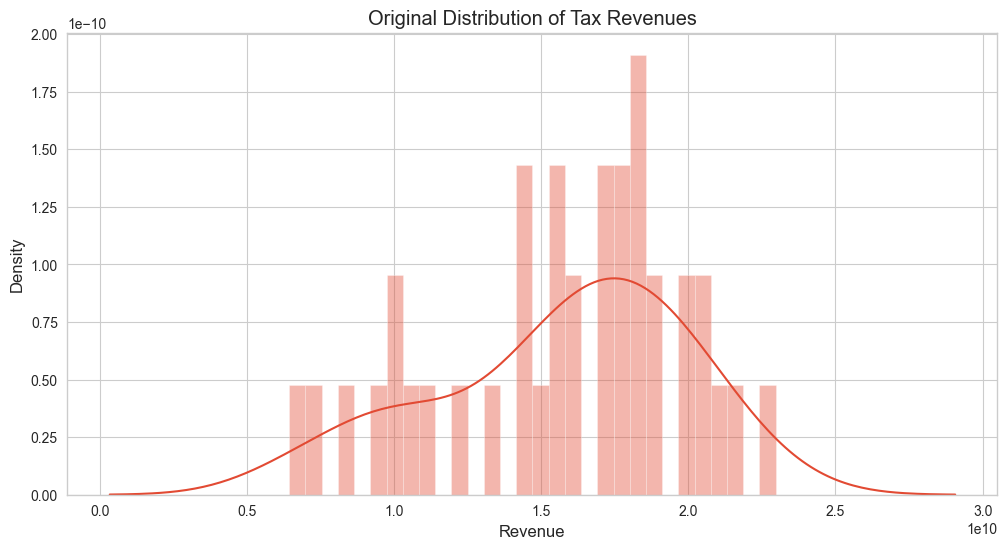

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plotting the original distribution of revenues
plt.figure(figsize=(12, 6))
sns.distplot(df_train['y'], bins=30, kde=True)
plt.title('Original Distribution of Tax Revenues')
plt.xlabel('Revenue')
plt.ylabel('Density')
plt.show()


In [122]:
from scipy.stats import boxcox

# The original data must be positive. If not, you may need to shift the data.
df_train['y'], fitted_lambda = boxcox(df_train['y'])  # Shift if necessary
print("Fitted Lambda: ", fitted_lambda)

Fitted Lambda:  1.7466056832806875


/var/folders/s8/n6hk73zn1g1chcp__tz8p0mw0000gn/T/ipykernel_76836/2207789776.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/s8/n6hk73zn1g1chcp__tz8p0mw0000gn/T/ipykernel_76836/2001345160.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




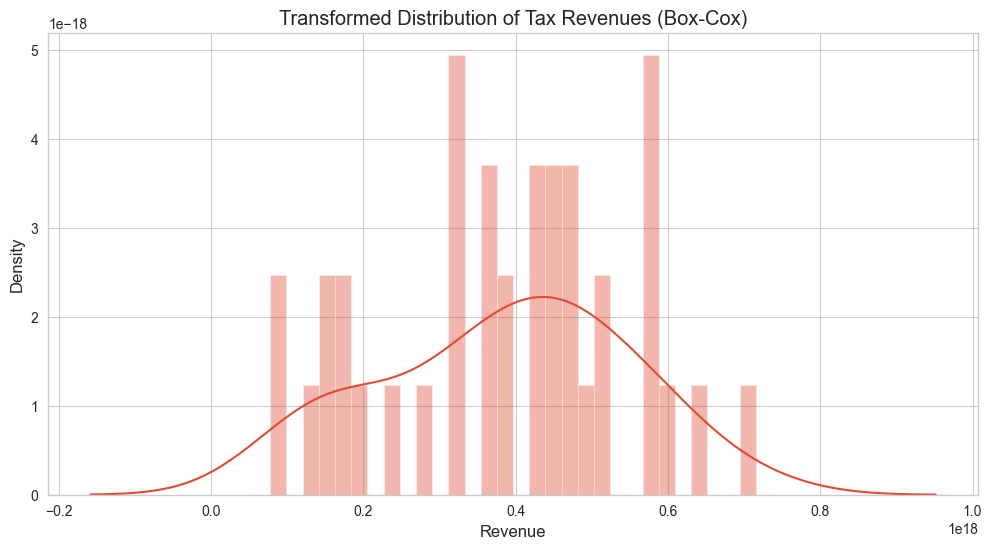

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plotting the original distribution of revenues
plt.figure(figsize=(12, 6))
sns.distplot(df_train['y'], bins=30, kde=True)
plt.title('Transformed Distribution of Tax Revenues (Box-Cox)')
plt.xlabel('Revenue')
plt.ylabel('Density')
plt.show()

In [124]:
import pandas as pd
from prophet import Prophet
from scipy import stats
from scipy.special import inv_boxcox
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation, performance_metrics

13:50:05 - cmdstanpy - INFO - Chain [1] start processing
13:50:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/2 [00:00<?, ?it/s]13:50:05 - cmdstanpy - INFO - Chain [1] start processing
13:50:06 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  5.07it/s]13:50:06 - cmdstanpy - INFO - Chain [1] start processing
13:50:06 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  5.13it/s]
/Users/lucaordronneau/miniconda3/envs/env/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



    horizon       mae       mse      rmse
0  363 days  0.264784  0.070110  0.264784
1  364 days  0.030599  0.000936  0.030599
2  728 days  0.196802  0.038731  0.196802
3  729 days  0.212402  0.045115  0.212402
4 1093 days  0.243148  0.059121  0.243148
5 1094 days  0.203161  0.041274  0.203161
6 1458 days  0.038831  0.001508  0.038831
7 1460 days  2.225291  4.951920  2.225291
8 1824 days  0.056885  0.003236  0.056885
9 1825 days  2.351779  5.530864  2.351779


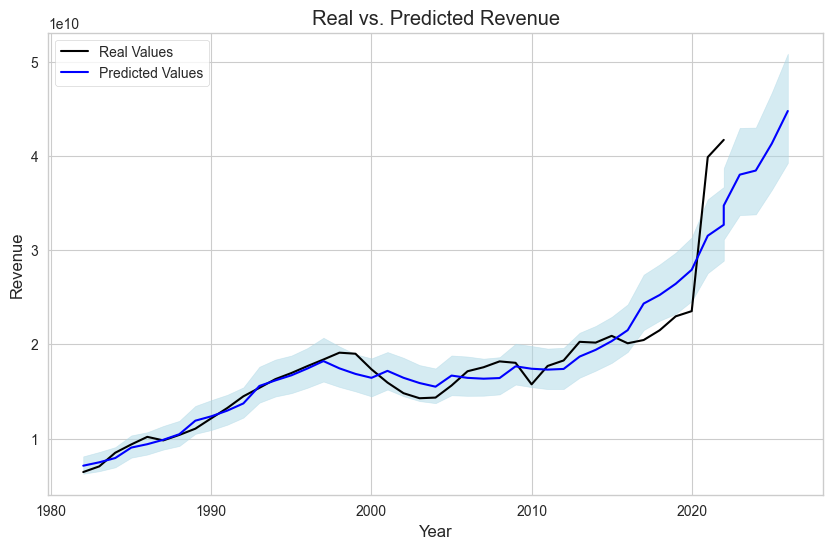

In [125]:
df_data_tmp = df_data.copy(deep=True)

# Apply Box-Cox transformation
df_data_tmp['REVENUE'], lambda_bc = boxcox(df_data_tmp['REVENUE'])

# Prepare data for Prophet
df_prophet = pd.DataFrame({
    'ds': pd.to_datetime(df_data_tmp['YEAR'], format='%Y'),
    'y': df_data_tmp['REVENUE']
})

# Initialize and fit the Prophet model
model = Prophet()
model.fit(df_prophet)

# Perform cross-validation with correct time units
df_cv = cross_validation(model, initial='10950 days', period='1825 days', horizon='1825 days')  # 30 years, 5 years, 5 years

# Compute performance metrics
df_p = performance_metrics(df_cv)

# Print error metrics for each fold
print(df_p[['horizon', 'mae', 'mse', 'rmse']])

# Forecast using the full model
future = model.make_future_dataframe(periods=5, freq='Y')
forecast = model.predict(future)

# Inverse Box-Cox transformation on forecasted values
forecast['yhat_inv'] = inv_boxcox(forecast['yhat'], lambda_bc)
forecast['yhat_lower_inv'] = inv_boxcox(forecast['yhat_lower'], lambda_bc)
forecast['yhat_upper_inv'] = inv_boxcox(forecast['yhat_upper'], lambda_bc)

# Plot real values vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_data_tmp['YEAR'], inv_boxcox(df_data_tmp['REVENUE'], lambda_bc), label='Real Values', color='black')
plt.plot(pd.to_datetime(forecast['ds']).dt.year, forecast['yhat_inv'], label='Predicted Values', color='blue')
plt.fill_between(pd.to_datetime(forecast['ds']).dt.year, forecast['yhat_lower_inv'], forecast['yhat_upper_inv'], color='lightblue', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.title('Real vs. Predicted Revenue')
plt.legend()
plt.show()


In [126]:
df_data_tmp['REVENUE'].tail(3)

38    51.381818
39    53.504342
40    53.688530
Name: REVENUE, dtype: float64

In [127]:
forecast['yhat'].tail(8).head(3)

38    52.063570
39    52.551841
40    52.698185
Name: yhat, dtype: float64

In [128]:
mean_squared_error(inv_boxcox(df_data_tmp['REVENUE'].tail(3).values, lambda_bc), inv_boxcox(forecast['yhat'].tail(8).head(3).values, lambda_bc))

5.669470159141765e+19

### XGBoost

In [131]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

/var/folders/s8/n6hk73zn1g1chcp__tz8p0mw0000gn/T/ipykernel_76836/3982776031.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Fold 1 Train Years: [1983 1984 1985 1986 1987]
Fold 1 Validation Years: [1988 1989 1990 1991]
Fold 1 MSE: 0.0005613469990047584
Fold 2 Train Years: [1983 1984 1985 1986 1987 1988 1989 1990 1991]
Fold 2 Validation Years: [1992 1993 1994 1995]
Fold 2 MSE: 0.0005291701316432687
Fold 3 Train Years: [1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995]
Fold 3 Validation Years: [1996 1997 1998 1999]
Fold 3 MSE: 0.0001489731717179427
Fold 4 Train Years: [1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999]
Fold 4 Validation Years: [2000 2001 2002 2003]
Fold 4 MSE: 7.76476460266746e-05
Fold 5 Train Years: [1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003]
Fold 5 Validation Years: [2004 2005 2006 2007]
Fold 5 MSE: 0.0003765009742917498
Fold 6 Train Years: [1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007]
Fold 6 Vali

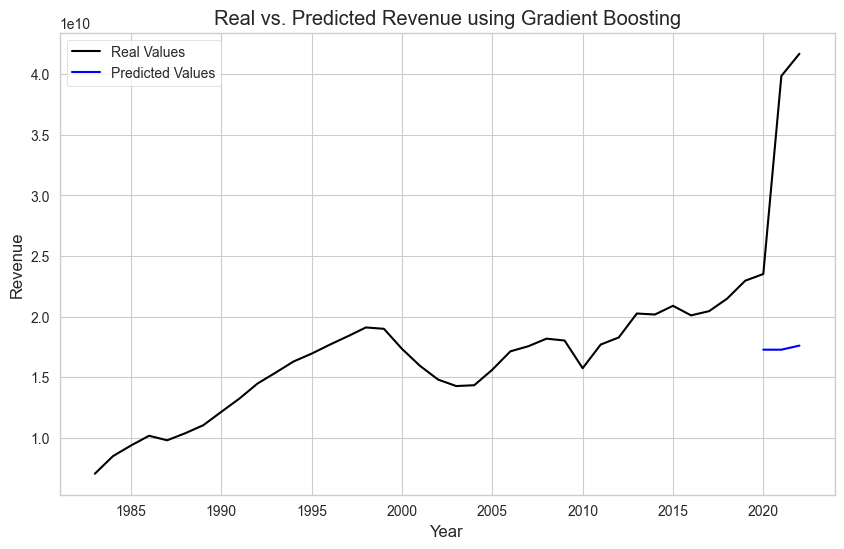

In [132]:
# Copy the data and apply Box-Cox transformation
df_sub_data = df_data[1:]
df_sub_data['REVENUE'], lambda_bc = boxcox(df_sub_data['REVENUE'])

# Define the test period
test_years = [df_sub_data['YEAR'].max() - 2, df_sub_data['YEAR'].max() - 1, df_sub_data['YEAR'].max()]
train_data = df_sub_data[~df_sub_data['YEAR'].isin(test_years)]
test_data = df_sub_data[df_sub_data['YEAR'].isin(test_years)]

# Prepare the features and target for model training
X_train = train_data.drop(["REVENUE", "YEAR"], axis=1)
y_train = train_data['REVENUE']
X_test = test_data.drop(["REVENUE", "YEAR"], axis=1)
y_test = test_data['REVENUE']

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# TimeSeriesSplit for proper time-series cross-validation
tscv = TimeSeriesSplit(n_splits=8)

# Initialize XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror')

# Parameters for Grid Search
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.005, 0.01, 0.1]
}

# Best parameter initialization
best_score = float("inf")
best_params = {}

# Lists to store cross-validation results
cv_errors = []
feature_importances = []

# Manually implementing cross-validation
for fold, (train_indices, val_indices) in enumerate(tscv.split(X_train_scaled)):
    X_train_fold, X_val_fold = pd.DataFrame(X_train_scaled).iloc[train_indices], pd.DataFrame(X_train_scaled).iloc[val_indices]
    y_train_fold, y_val_fold = y_train.iloc[train_indices], y_train.iloc[val_indices]

    # Get the corresponding years for train and validation
    train_years = train_data['YEAR'].iloc[train_indices].values
    val_years = train_data['YEAR'].iloc[val_indices].values

    print(f'Fold {fold + 1} Train Years: {train_years}')
    print(f'Fold {fold + 1} Validation Years: {val_years}')

    for max_depth in param_grid['max_depth']:
        for n_estimators in param_grid['n_estimators']:
            for learning_rate in param_grid['learning_rate']:
                # Set parameters
                xgb_model.set_params(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate)
                # Fit model
                xgb_model.fit(X_train_fold, y_train_fold)
                # Predict on validation fold
                predictions = xgb_model.predict(X_val_fold)
                # Calculate error
                mse = mean_squared_error(y_val_fold, predictions)

                # Update best parameters if current model is better
                if mse < best_score:
                    best_score = mse
                    best_params = {'max_depth': max_depth, 'n_estimators': n_estimators, 'learning_rate': learning_rate}

    # Fit the best model on the current fold
    xgb_model.set_params(**best_params)
    xgb_model.fit(X_train_fold, y_train_fold)
    predictions = xgb_model.predict(X_val_fold)
    mse = mean_squared_error(y_val_fold, predictions)
    cv_errors.append(mse)
    print(f'Fold {fold + 1} MSE: {mse}')

    # Get feature importances and print top 5
    fold_feature_importances = xgb_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': fold_feature_importances
    }).sort_values(by='importance', ascending=False)
    
    # print(f'Top 5 feature importances for fold {fold + 1}:')
    # print(feature_importance_df.head(5))

    feature_importances.append(feature_importance_df.head(5))

# Fit the best model on the entire training data
best_xgb_model = XGBRegressor(**best_params)
best_xgb_model.fit(X_train_scaled, y_train)

# Make predictions
xgb_predictions = best_xgb_model.predict(X_test_scaled)

# Inverse Box-Cox transformation on forecasted values
xgb_predictions_inv = inv_boxcox(xgb_predictions, lambda_bc)

# Prepare the forecast dataframe
forecast_df = pd.DataFrame({
    'YEAR': test_data['YEAR'],
    'PREDICTED_REVENUE': xgb_predictions_inv
})

# Plot real values vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_sub_data['YEAR'], inv_boxcox(df_sub_data['REVENUE'], lambda_bc), label='Real Values', color='black')
plt.plot(forecast_df['YEAR'], forecast_df['PREDICTED_REVENUE'], label='Predicted Values', color='blue')
plt.fill_between(forecast_df['YEAR'], forecast_df['PREDICTED_REVENUE'], forecast_df['PREDICTED_REVENUE'], color='lightblue', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.title('Real vs. Predicted Revenue using Gradient Boosting')
plt.legend()
plt.show()

In [133]:
df_sub_data['REVENUE'].tail(3).values

array([9.74128623, 9.79996738, 9.80484721])

In [134]:
mean_squared_error(inv_boxcox(df_sub_data['REVENUE'].tail(3).values, lambda_bc), inv_boxcox(xgb_predictions, lambda_bc))

3.7635549687685245e+20